##  Ejercicio resuelto Samai

### Fase 1: Exploración y Limpieza
 
1. **Exploración Inicial:**

   - Realiza una exploración inicial de los datos para identificar posibles problemas, como valores nulos, atípicos o datos faltantes en las columnas relevantes.

   - Utiliza funciones de Pandas para obtener información sobre la estructura de los datos, la presencia de valores nulos y estadísticas básicas de las columnas involucradas.

   - Une los dos conjuntos de datos de la forma más eficiente.

2. **Limpieza de Datos:**
   - Elimina o trata los valores nulos, si los hay, en las columnas clave para asegurar que los datos estén completos.
   - Verifica la consistencia y corrección de los datos para asegurarte de que los datos se presenten de forma coherente.
   - Realiza cualquier ajuste o conversión necesaria en las columnas (por ejemplo, cambiar tipos de datos) para garantizar la adecuación de los datos para el análisis estadístico.

In [40]:
# Importo las librerías necesarias, incorporo los "antiwarning" e instalo motores para poder guardar en parquet:

import pandas as pd
import numpy as np
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")  # ignora todos los warnings
# Silenciar categorías típicas de pandas:
from pandas.errors import SettingWithCopyWarning, DtypeWarning
warnings.simplefilter("ignore", SettingWithCopyWarning)
warnings.simplefilter("ignore", DtypeWarning)
warnings.simplefilter("ignore", FutureWarning)
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations

!pip install pyarrow
!pip install fastparquet


In [3]:
# 1. EXPLORACIÓN:

# Antes de proceder al EDA, creo una función que trate (si aplica) aquellas columnas que vengan como tipo 'object'...
#...Cuando en realidad debieran ser de otro tipo. Y así poder obtener un EDA más preciso sobre columnas numéricas/categóricas.

def convert_to_right_type(df, name="DataFrame"):
    """
    Convierte automáticamente columnas object que puedan ser numéricas, de tipo fecha o categóricas.
    - Muestra sobre qué DF trabaja y cada cambio de tipo por columna.
    - Devuelve (df, resumen_cambios)
    """
    warnings.filterwarnings("ignore", category=UserWarning)

    # Para el resumen de cambios
    changes = []

    print(f"\n{'='*90}")
    print(f"🔄 CONVERSIÓN DE TIPOS → DF: {name} | shape={df.shape}")
    print(f"{'='*90}")

    obj_cols = df.select_dtypes(include='object').columns.tolist()
    print(f"🔎 Columnas 'object' detectadas: {len(obj_cols)} → {obj_cols if len(obj_cols) <= 20 else obj_cols[:20] + ['…']}")

    conv_num = conv_date = conv_cat = 0

    for col in obj_cols:
        old_type = df[col].dtype.name

        # Intento a numérico (solo si TODOS los valores son convertibles)
        num = pd.to_numeric(df[col], errors='coerce')
        if num.notna().sum() == len(df[col]):
            df[col] = num
            conv_num += 1
            changes.append({"Columna": col, "Antes": old_type, "Después": str(df[col].dtype), "Conversión": "numeric"})
            print(f"✅ [{name}] '{col}': {old_type} → numérico ({df[col].dtype})")
            continue

        # Intento a datetime (solo si TODOS los valores son convertibles)
        fechas = pd.to_datetime(df[col], errors='coerce', dayfirst=False, infer_datetime_format=True)
        if fechas.notna().sum() == len(df[col]):
            df[col] = fechas
            conv_date += 1
            changes.append({"Columna": col, "Antes": old_type, "Después": "datetime64[ns]", "Conversión": "datetime"})
            print(f"📅 [{name}] '{col}': {old_type} → datetime")
            continue

        # Si no es ni número ni fecha, convertir a categoría
        df[col] = df[col].astype('category')
        conv_cat += 1
        changes.append({"Columna": col, "Antes": old_type, "Después": str(df[col].dtype), "Conversión": "category"})
        print(f"🏷️ [{name}] '{col}': {old_type} → category")

    # Resumen final
    from IPython.display import display
    type_convert_summary = pd.DataFrame(changes, columns=["Columna", "Antes", "Después", "Conversión"])

    print("\n— Resumen de conversiones —")
    print(f"  • A numérico : {conv_num}")
    print(f"  • A datetime : {conv_date}")
    print(f"  • A category : {conv_cat}")

    if not type_convert_summary.empty:
        print("\n📋 Detalle de cambios por columna:")
        display(type_convert_summary)
    else:
        print("ℹ️ No se detectaron columnas 'object' para convertir.")

    print(f"✅ Conversión completada para DF: {name}\n")

    warnings.resetwarnings()
    return df, type_convert_summary

# Ahora creo una función de EDA para aplicar a ambos conjuntos de datos:

def eda(df, name="DataFrame"):
    """
    Realiza un análisis exploratorio de datos sobre un DataFrame ya limpio.
    Incluye mensajes claros y tablas resumen.
    """
    print(f"\n{'='*90}")
    print(f"📊 EDA DEL DATAFRAME: {name}")
    print(f"{'='*90}")

    # --- Primeras y últimas filas
    print("\n🔹 Primeras 10 filas:")
    display(df.head(10))

    print("\n🔹 Últimas 10 filas:")
    display(df.tail(10))

    # --- Dimensiones
    print("\n🔹 Dimensiones (filas, columnas):", df.shape)

    # --- Información general
    print("\n🔹 Información general del DataFrame:")
    df.info()

    # --- Tipos de datos
    print("\n🔹 Tipos de datos por columna:")
    print(df.dtypes)

    # --- Estadísticas numéricas
    num_cols = df.select_dtypes(include='number').columns
    if len(num_cols) > 0:
        print("\n📈 Estadísticas de variables numéricas:")
        display(df[num_cols].describe().T)
    else:
        print("\nℹ️ No hay columnas numéricas.")

    # --- Estadísticas categóricas
    cat_cols = df.select_dtypes(include=['object','category']).columns
    if len(cat_cols) > 0:
        print("\n🏷️ Estadísticas de variables categóricas:")
        display(df[cat_cols].describe().T)
    else:
        print("\nℹ️ No hay columnas categóricas.")

    # --- Valores nulos
    print("\n🔎 Valores nulos por columna:")
    nulls_df = pd.DataFrame({
        "Conteo": df.isnull().sum(),
        "Porcentaje": (df.isnull().sum()/len(df)*100).round(2)
    }).sort_values(by="Porcentaje", ascending=False)
    display(nulls_df)

    # --- Filas duplicadas
    print(f"\n🔁 Filas duplicadas: {df.duplicated().sum()}")

    # --- Valores únicos
    print("\n🔹 Número de valores únicos por columna:")
    display(df.nunique().sort_values(ascending=False))

    # --- Distribución de variables categóricas
    if len(cat_cols) > 0:
        print("\n🔎 Distribución (Top 5) de variables categóricas:")
        for col in cat_cols:
            print(f"\n▶ {col}")
            display(df[col].value_counts(dropna=False).head())
    else:
        print("\nℹ️ No hay columnas categóricas para mostrar distribución.")

    # --- Resumen general
    eda_summary = pd.DataFrame({
        "Columna": df.columns,
        "Tipo de dato": df.dtypes.astype(str),
        "Valores únicos": df.nunique().values,
        "% Nulos": (df.isnull().sum()/len(df)*100).round(2).values
    })

    print("\n📋 RESUMEN GENERAL DE COLUMNAS:")
    display(eda_summary)

    # --- Resumen de columnas con nulos
    eda_nulls_summary = eda_summary[eda_summary["% Nulos"] > 0].sort_values(by="% Nulos", ascending=False)
    if not eda_nulls_summary.empty:
        print("\n⚠️ COLUMNAS CON VALORES NULOS:")
        display(eda_nulls_summary)
    else:
        print("\n✅ No hay columnas con valores nulos.")

    print(f"\n✅ EDA de '{name}' completado.\n")

    return eda_summary, eda_nulls_summary


In [4]:
# Para ver todas las columnas y todas las filas y ajustar el ancho de pantalla para que no seccione las columnas:

pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 2000)

# Para cargar/leer los csv's:

df_Flight = pd.read_csv("Customer Flight Activity.csv")   
df_Loyalty = pd.read_csv("Customer Loyalty History.csv")  

# Aplico la función de conversión inicial a cada conjunto de datos:

convert_to_right_type(df_Flight, name="df_Flight")
convert_to_right_type(df_Loyalty, name="df_Loyalty")


🔄 CONVERSIÓN DE TIPOS → DF: df_Flight | shape=(405624, 10)
🔎 Columnas 'object' detectadas: 0 → []

— Resumen de conversiones —
  • A numérico : 0
  • A datetime : 0
  • A category : 0
ℹ️ No se detectaron columnas 'object' para convertir.
✅ Conversión completada para DF: df_Flight


🔄 CONVERSIÓN DE TIPOS → DF: df_Loyalty | shape=(16737, 16)
🔎 Columnas 'object' detectadas: 9 → ['Country', 'Province', 'City', 'Postal Code', 'Gender', 'Education', 'Marital Status', 'Loyalty Card', 'Enrollment Type']
🏷️ [df_Loyalty] 'Country': object → category
🏷️ [df_Loyalty] 'Province': object → category
🏷️ [df_Loyalty] 'City': object → category
🏷️ [df_Loyalty] 'Postal Code': object → category
🏷️ [df_Loyalty] 'Gender': object → category
🏷️ [df_Loyalty] 'Education': object → category
🏷️ [df_Loyalty] 'Marital Status': object → category
🏷️ [df_Loyalty] 'Loyalty Card': object → category
🏷️ [df_Loyalty] 'Enrollment Type': object → category

— Resumen de conversiones —
  • A numérico : 0
  • A datetime : 0
  •

Columna   Antes   Después Conversión
0          Country  object  category   category
1         Province  object  category   category
2             City  object  category   category
3      Postal Code  object  category   category
4           Gender  object  category   category
5        Education  object  category   category
6   Marital Status  object  category   category
7     Loyalty Card  object  category   category
8  Enrollment Type  object  category   category

✅ Conversión completada para DF: df_Loyalty



(       Loyalty Number Country              Province            City Postal Code  Gender             Education    Salary Marital Status Loyalty Card       CLV Enrollment Type  Enrollment Year  Enrollment Month  Cancellation Year  Cancellation Month
 0              480934  Canada               Ontario         Toronto     M2Z 4K1  Female              Bachelor   83236.0        Married         Star   3839.14        Standard             2016                 2                NaN                 NaN
 1              549612  Canada               Alberta        Edmonton     T3G 6Y6    Male               College       NaN       Divorced         Star   3839.61        Standard             2016                 3                NaN                 NaN
 2              429460  Canada      British Columbia       Vancouver     V6E 3D9    Male               College       NaN         Single         Star   3839.75        Standard             2014                 7             2018.0                 1.0
 3  

In [5]:
# Y ahora puedo aplicar la función de EDA a ambos:

eda(df_Flight, "Customer Flight Activity")
eda(df_Loyalty, "Customer Loyalty History")


📊 EDA DEL DATAFRAME: Customer Flight Activity

🔹 Primeras 10 filas:


Loyalty Number  Year  Month  Flights Booked  Flights with Companions  Total Flights  Distance  Points Accumulated  Points Redeemed  Dollar Cost Points Redeemed
0          100018  2017      1               3                        0              3      1521               152.0                0                            0
1          100102  2017      1              10                        4             14      2030               203.0                0                            0
2          100140  2017      1               6                        0              6      1200               120.0                0                            0
3          100214  2017      1               0                        0              0         0                 0.0                0                            0
4          100272  2017      1               0                        0              0         0                 0.0                0                            0
5          100301  2017      1               0                        0              0         0                 0.0                0                            0
6          100364  2017      1               0                        0              0         0                 0.0                0                            0
7          100380  2017      1               0                        0              0         0                 0.0                0                            0
8          100428  2017      1               6                        0              6       606                60.0                0                            0
9          100504  2017      1               0                        0              0         0                 0.0                0                            0


🔹 Últimas 10 filas:


Loyalty Number  Year  Month  Flights Booked  Flights with Companions  Total Flights  Distance  Points Accumulated  Points Redeemed  Dollar Cost Points Redeemed
405614          999631  2018     12              11                        1             12      2244               224.0                0                            0
405615          999891  2018     10               0                        0              0         0                 0.0                0                            0
405616          999758  2018     12               1                        0              1       896                89.0                0                            0
405617          999891  2018     11               0                        0              0         0                 0.0                0                            0
405618          999891  2018     12               0                        0              0         0                 0.0                0                            0
405619          999902  2018     12               0                        0              0         0                 0.0                0                            0
405620          999911  2018     12               0                        0              0         0                 0.0                0                            0
405621          999940  2018     12               3                        0              3      1233               123.0                0                            0
405622          999982  2018     12               0                        0              0         0                 0.0                0                            0
405623          999986  2018     12               0                        0              0         0                 0.0                0                            0


🔹 Dimensiones (filas, columnas): (405624, 10)

🔹 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB

🔹 Tipos de datos por columna:
Loyalty Number

count           mean            std       min        25%       50%        75%       max
Loyalty Number               405624.0  550037.873084  258935.286969  100018.0  326961.00  550834.0  772194.00  999986.0
Year                         405624.0    2017.500000       0.500001    2017.0    2017.00    2017.5    2018.00    2018.0
Month                        405624.0       6.500000       3.452057       1.0       3.75       6.5       9.25      12.0
Flights Booked               405624.0       4.115052       5.225518       0.0       0.00       1.0       8.00      21.0
Flights with Companions      405624.0       1.031805       2.076869       0.0       0.00       0.0       1.00      11.0
Total Flights                405624.0       5.146858       6.521227       0.0       0.00       1.0      10.00      32.0
Distance                     405624.0    1208.880059    1433.155320       0.0       0.00     488.0    2336.00    6293.0
Points Accumulated           405624.0     123.692721     146.599831       0.0       0.00      50.0     239.00     676.5
Points Redeemed              405624.0      30.696872     125.486049       0.0       0.00       0.0       0.00     876.0
Dollar Cost Points Redeemed  405624.0       2.484503      10.150038       0.0       0.00       0.0       0.00      71.0


ℹ️ No hay columnas categóricas.

🔎 Valores nulos por columna:


Conteo  Porcentaje
Loyalty Number                    0         0.0
Year                              0         0.0
Month                             0         0.0
Flights Booked                    0         0.0
Flights with Companions           0         0.0
Total Flights                     0         0.0
Distance                          0         0.0
Points Accumulated                0         0.0
Points Redeemed                   0         0.0
Dollar Cost Points Redeemed       0         0.0


🔁 Filas duplicadas: 1864

🔹 Número de valores únicos por columna:


Loyalty Number                 16737
Distance                        4746
Points Accumulated              1549
Points Redeemed                  587
Dollar Cost Points Redeemed       49
Total Flights                     33
Flights Booked                    22
Flights with Companions           12
Month                             12
Year                               2
dtype: int64


ℹ️ No hay columnas categóricas para mostrar distribución.

📋 RESUMEN GENERAL DE COLUMNAS:


Columna Tipo de dato  Valores únicos  % Nulos
Loyalty Number                            Loyalty Number        int64           16737      0.0
Year                                                Year        int64               2      0.0
Month                                              Month        int64              12      0.0
Flights Booked                            Flights Booked        int64              22      0.0
Flights with Companions          Flights with Companions        int64              12      0.0
Total Flights                              Total Flights        int64              33      0.0
Distance                                        Distance        int64            4746      0.0
Points Accumulated                    Points Accumulated      float64            1549      0.0
Points Redeemed                          Points Redeemed        int64             587      0.0
Dollar Cost Points Redeemed  Dollar Cost Points Redeemed        int64              49      0.0


✅ No hay columnas con valores nulos.

✅ EDA de 'Customer Flight Activity' completado.


📊 EDA DEL DATAFRAME: Customer Loyalty History

🔹 Primeras 10 filas:


Loyalty Number Country          Province        City Postal Code  Gender Education    Salary Marital Status Loyalty Card      CLV Enrollment Type  Enrollment Year  Enrollment Month  Cancellation Year  Cancellation Month
0          480934  Canada           Ontario     Toronto     M2Z 4K1  Female  Bachelor   83236.0        Married         Star  3839.14        Standard             2016                 2                NaN                 NaN
1          549612  Canada           Alberta    Edmonton     T3G 6Y6    Male   College       NaN       Divorced         Star  3839.61        Standard             2016                 3                NaN                 NaN
2          429460  Canada  British Columbia   Vancouver     V6E 3D9    Male   College       NaN         Single         Star  3839.75        Standard             2014                 7             2018.0                 1.0
3          608370  Canada           Ontario     Toronto     P1W 1K4    Male   College       NaN         Single         Star  3839.75        Standard             2013                 2                NaN                 NaN
4          530508  Canada            Quebec        Hull     J8Y 3Z5    Male  Bachelor  103495.0        Married         Star  3842.79        Standard             2014                10                NaN                 NaN
5          193662  Canada             Yukon  Whitehorse     Y2K 6R0    Male  Bachelor   51124.0        Married         Star  3844.57        Standard             2012                 5                NaN                 NaN
6          927943  Canada           Ontario     Toronto     P5S 6R4  Female   College       NaN         Single         Star  3857.95        Standard             2014                 6                NaN                 NaN
7          188893  Canada           Ontario     Trenton     K8V 4B2    Male  Bachelor  100159.0        Married         Star  3861.49        Standard             2016                12                NaN                 NaN
8          852392  Canada            Quebec    Montreal     H2Y 2W2  Female  Bachelor  100159.0        Married         Star  3861.49        Standard             2015                 5                NaN                 NaN
9          866307  Canada           Ontario     Toronto     M8Y 4K8    Male  Bachelor  100159.0        Married         Star  3861.49        Standard             2016                10                NaN                 NaN


🔹 Últimas 10 filas:


Loyalty Number Country          Province        City Postal Code  Gender Education   Salary Marital Status Loyalty Card       CLV Enrollment Type  Enrollment Year  Enrollment Month  Cancellation Year  Cancellation Month
16727          546773  Canada  British Columbia   Vancouver     V6E 3D9    Male   College      NaN        Married         Star  52811.49        Standard             2015                 9                NaN                 NaN
16728          302628  Canada            Quebec   Tremblant     H5Y 2S9    Male  Bachelor  61718.0         Single         Star  55277.45        Standard             2013                 3                NaN                 NaN
16729          302460  Canada  British Columbia    Whistler     V6T 1Y8  Female  Bachelor  88425.0        Married         Star  56675.94        Standard             2014                 9                NaN                 NaN
16730          672917  Canada           Ontario     Toronto     M1R 4K3  Female  Bachelor  76778.0         Single         Star  58166.55        Standard             2015                 1             2015.0                 9.0
16731          900501  Canada           Ontario     Sudbury     M5V 1G5    Male   College      NaN         Single         Star  61134.68        Standard             2012                 9                NaN                 NaN
16732          823768  Canada  British Columbia   Vancouver     V6E 3Z3  Female   College      NaN        Married         Star  61850.19        Standard             2012                12                NaN                 NaN
16733          680886  Canada      Saskatchewan      Regina     S1J 3C5  Female  Bachelor  89210.0        Married         Star  67907.27        Standard             2014                 9                NaN                 NaN
16734          776187  Canada  British Columbia   Vancouver     V5R 1W3    Male   College      NaN         Single         Star  74228.52        Standard             2014                 3                NaN                 NaN
16735          906428  Canada             Yukon  Whitehorse     Y2K 6R0    Male  Bachelor -57297.0        Married         Star  10018.66  2018 Promotion             2018                 4                NaN                 NaN
16736          652627  Canada          Manitoba    Winnipeg     R2C 0M5  Female  Bachelor  75049.0        Married         Star  83325.38        Standard             2015                12             2016.0                 8.0


🔹 Dimensiones (filas, columnas): (16737, 16)

🔹 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Loyalty Number      16737 non-null  int64   
 1   Country             16737 non-null  category
 2   Province            16737 non-null  category
 3   City                16737 non-null  category
 4   Postal Code         16737 non-null  category
 5   Gender              16737 non-null  category
 6   Education           16737 non-null  category
 7   Salary              12499 non-null  float64 
 8   Marital Status      16737 non-null  category
 9   Loyalty Card        16737 non-null  category
 10  CLV                 16737 non-null  float64 
 11  Enrollment Type     16737 non-null  category
 12  Enrollment Year     16737 non-null  int64   
 13  Enrollment Month    16737 non-null  int64   
 14  Ca

count           mean            std        min        25%        50%        75%        max
Loyalty Number      16737.0  549735.880445  258912.132453  100018.00  326603.00  550434.00  772019.00  999986.00
Salary              12499.0   79245.609409   35008.297285  -58486.00   59246.50   73455.00   88517.50  407228.00
CLV                 16737.0    7988.896536    6860.982280    1898.01    3980.84    5780.18    8940.58   83325.38
Enrollment Year     16737.0    2015.253211       1.979111    2012.00    2014.00    2015.00    2017.00    2018.00
Enrollment Month    16737.0       6.669116       3.398958       1.00       4.00       7.00      10.00      12.00
Cancellation Year    2067.0    2016.503145       1.380743    2013.00    2016.00    2017.00    2018.00    2018.00
Cancellation Month   2067.0       6.962748       3.455297       1.00       4.00       7.00      10.00      12.00


🏷️ Estadísticas de variables categóricas:


count unique       top   freq
Country          16737      1    Canada  16737
Province         16737     11   Ontario   5404
City             16737     29   Toronto   3351
Postal Code      16737     55   V6E 3D9    911
Gender           16737      2    Female   8410
Education        16737      5  Bachelor  10475
Marital Status   16737      3   Married   9735
Loyalty Card     16737      3      Star   7637
Enrollment Type  16737      2  Standard  15766


🔎 Valores nulos por columna:


Conteo  Porcentaje
Cancellation Month   14670       87.65
Cancellation Year    14670       87.65
Salary                4238       25.32
Loyalty Number           0        0.00
City                     0        0.00
Postal Code              0        0.00
Province                 0        0.00
Country                  0        0.00
Education                0        0.00
Gender                   0        0.00
Marital Status           0        0.00
Loyalty Card             0        0.00
Enrollment Type          0        0.00
CLV                      0        0.00
Enrollment Month         0        0.00
Enrollment Year          0        0.00


🔁 Filas duplicadas: 0

🔹 Número de valores únicos por columna:


Loyalty Number        16737
CLV                    7984
Salary                 5890
Postal Code              55
City                     29
Enrollment Month         12
Cancellation Month       12
Province                 11
Enrollment Year           7
Cancellation Year         6
Education                 5
Marital Status            3
Loyalty Card              3
Gender                    2
Enrollment Type           2
Country                   1
dtype: int64


🔎 Distribución (Top 5) de variables categóricas:

▶ Country


Country
Canada    16737
Name: count, dtype: int64


▶ Province


Province
Ontario             5404
British Columbia    4409
Quebec              3300
Alberta              969
Manitoba             658
Name: count, dtype: int64


▶ City


City
Toronto      3351
Vancouver    2582
Montreal     2059
Winnipeg      658
Whistler      582
Name: count, dtype: int64


▶ Postal Code


Postal Code
V6E 3D9    911
V5R 1W3    684
V6T 1Y8    582
V6E 3Z3    544
M2M 7K8    534
Name: count, dtype: int64


▶ Gender


Gender
Female    8410
Male      8327
Name: count, dtype: int64


▶ Education


Education
Bachelor                10475
College                  4238
High School or Below      782
Doctor                    734
Master                    508
Name: count, dtype: int64


▶ Marital Status


Marital Status
Married     9735
Single      4484
Divorced    2518
Name: count, dtype: int64


▶ Loyalty Card


Loyalty Card
Star      7637
Nova      5671
Aurora    3429
Name: count, dtype: int64


▶ Enrollment Type


Enrollment Type
Standard          15766
2018 Promotion      971
Name: count, dtype: int64


📋 RESUMEN GENERAL DE COLUMNAS:


Columna Tipo de dato  Valores únicos  % Nulos
Loyalty Number          Loyalty Number        int64           16737     0.00
Country                        Country     category               1     0.00
Province                      Province     category              11     0.00
City                              City     category              29     0.00
Postal Code                Postal Code     category              55     0.00
Gender                          Gender     category               2     0.00
Education                    Education     category               5     0.00
Salary                          Salary      float64            5890    25.32
Marital Status          Marital Status     category               3     0.00
Loyalty Card              Loyalty Card     category               3     0.00
CLV                                CLV      float64            7984     0.00
Enrollment Type        Enrollment Type     category               2     0.00
Enrollment Year        Enrollment Year        int64               7     0.00
Enrollment Month      Enrollment Month        int64              12     0.00
Cancellation Year    Cancellation Year      float64               6    87.65
Cancellation Month  Cancellation Month      float64              12    87.65


⚠️ COLUMNAS CON VALORES NULOS:


Columna Tipo de dato  Valores únicos  % Nulos
Cancellation Year    Cancellation Year      float64               6    87.65
Cancellation Month  Cancellation Month      float64              12    87.65
Salary                          Salary      float64            5890    25.32


✅ EDA de 'Customer Loyalty History' completado.



(                               Columna Tipo de dato  Valores únicos  % Nulos
 Loyalty Number          Loyalty Number        int64           16737     0.00
 Country                        Country     category               1     0.00
 Province                      Province     category              11     0.00
 City                              City     category              29     0.00
 Postal Code                Postal Code     category              55     0.00
 Gender                          Gender     category               2     0.00
 Education                    Education     category               5     0.00
 Salary                          Salary      float64            5890    25.32
 Marital Status          Marital Status     category               3     0.00
 Loyalty Card              Loyalty Card     category               3     0.00
 CLV                                CLV      float64            7984     0.00
 Enrollment Type        Enrollment Type     category            

In [6]:
# Para determinar si hay alguna columna en común (como se anticipa) por la que unir los dos df:

print(df_Flight.columns)
print(df_Loyalty.columns)

Index(['Loyalty Number', 'Year', 'Month', 'Flights Booked', 'Flights with Companions', 'Total Flights', 'Distance', 'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'], dtype='object')
Index(['Loyalty Number', 'Country', 'Province', 'City', 'Postal Code', 'Gender', 'Education', 'Salary', 'Marital Status', 'Loyalty Card', 'CLV', 'Enrollment Type', 'Enrollment Year', 'Enrollment Month', 'Cancellation Year', 'Cancellation Month'], dtype='object')


In [7]:
# Visto que ambos comparten 'Loyalty Number', puedo unirlos por esta columna. Lo más apropiado es hacer un merge/outer:

full_customer_df = pd.merge(df_Flight, df_Loyalty, on="Loyalty Number", # > Para unir por esta columna, manteniéndola como tal (y no por índice - join -)
                            how="outer") # > Para conservar todas las filas unque no haya coincidencias.

# Verifico el resultado:

full_customer_df.head(5) #...y las columnas provinientes del otro df aparezcan a "NaN".

Loyalty Number  Year  Month  Flights Booked  Flights with Companions  Total Flights  Distance  Points Accumulated  Points Redeemed  Dollar Cost Points Redeemed Country Province      City Postal Code  Gender Education   Salary Marital Status Loyalty Card     CLV Enrollment Type  Enrollment Year  Enrollment Month  Cancellation Year  Cancellation Month
0          100018  2017      1               3                        0              3      1521               152.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
1          100018  2017      2               2                        2              4      1320               132.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
2          100018  2018     10               6                        4             10      3110               311.0              385                           31  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
3          100018  2017      4               4                        0              4       924                92.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
4          100018  2017      5               0                        0              0         0                 0.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN

In [8]:
# Una vez creado el nuevo Data Frame, a partir de la unión de los dos anteriores, procedo al punto 2 del ejercicio.
# Para lo cual, antes de nada, voy a pasarle a este nuevo df, la función de EDA, para tener una visión más aproximada del conjunto.

eda_summary, eda_nulls_summary = eda(full_customer_df, name="full_customer_df")


📊 EDA DEL DATAFRAME: full_customer_df

🔹 Primeras 10 filas:


Loyalty Number  Year  Month  Flights Booked  Flights with Companions  Total Flights  Distance  Points Accumulated  Points Redeemed  Dollar Cost Points Redeemed Country Province      City Postal Code  Gender Education   Salary Marital Status Loyalty Card     CLV Enrollment Type  Enrollment Year  Enrollment Month  Cancellation Year  Cancellation Month
0          100018  2017      1               3                        0              3      1521               152.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
1          100018  2017      2               2                        2              4      1320               132.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
2          100018  2018     10               6                        4             10      3110               311.0              385                           31  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
3          100018  2017      4               4                        0              4       924                92.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
4          100018  2017      5               0                        0              0         0                 0.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
5          100018  2017      6               4                        1              5      4330               433.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
6          100018  2017      7              10                        0             10      3870               387.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
7          100018  2017      9               9                        4             13      1651               165.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
8          100018  2017      8              10                        5             15      4200               420.0              690                           56  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN
9          100018  2017     10               6                        0              6      1032               103.0                0                            0  Canada  Alberta  Edmonton     T9G 1W3  Female  Bachelor  92552.0        Married       Aurora  7919.2        Standard             2016                 8                NaN                 NaN


🔹 Últimas 10 filas:


Loyalty Number  Year  Month  Flights Booked  Flights with Companions  Total Flights  Distance  Points Accumulated  Points Redeemed  Dollar Cost Points Redeemed Country Province    City Postal Code  Gender Education   Salary Marital Status Loyalty Card      CLV Enrollment Type  Enrollment Year  Enrollment Month  Cancellation Year  Cancellation Month
405614          999986  2018      3               5                        2              7      3283               410.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405615          999986  2018      4               0                        0              0         0                 0.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405616          999986  2017      4               5                        4              9      1845               184.0              527                           43  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405617          999986  2018      5               0                        0              0         0                 0.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405618          999986  2018      6               0                        0              0         0                 0.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405619          999986  2018      7              15                        0             15      1995               199.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405620          999986  2018      9               0                        0              0         0                 0.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405621          999986  2018     10               6                        0              6       708                70.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405622          999986  2018     11              11                        4             15      2040               204.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN
405623          999986  2018     12               0                        0              0         0                 0.0                0                            0  Canada  Ontario  Ottawa     K1F 2R2  Female  Bachelor  46594.0        Married         Nova  8257.01  2018 Promotion             2018                 2                NaN                 NaN


🔹 Dimensiones (filas, columnas): (405624, 25)

🔹 Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Loyalty Number               405624 non-null  int64   
 1   Year                         405624 non-null  int64   
 2   Month                        405624 non-null  int64   
 3   Flights Booked               405624 non-null  int64   
 4   Flights with Companions      405624 non-null  int64   
 5   Total Flights                405624 non-null  int64   
 6   Distance                     405624 non-null  int64   
 7   Points Accumulated           405624 non-null  float64 
 8   Points Redeemed              405624 non-null  int64   
 9   Dollar Cost Points Redeemed  405624 non-null  int64   
 10  Country                      405624 non-null  category
 11  Province           

count           mean            std        min        25%        50%        75%        max
Loyalty Number               405624.0  550037.873084  258935.286969  100018.00  326961.00  550834.00  772194.00  999986.00
Year                         405624.0    2017.500000       0.500001    2017.00    2017.00    2017.50    2018.00    2018.00
Month                        405624.0       6.500000       3.452057       1.00       3.75       6.50       9.25      12.00
Flights Booked               405624.0       4.115052       5.225518       0.00       0.00       1.00       8.00      21.00
Flights with Companions      405624.0       1.031805       2.076869       0.00       0.00       0.00       1.00      11.00
Total Flights                405624.0       5.146858       6.521227       0.00       0.00       1.00      10.00      32.00
Distance                     405624.0    1208.880059    1433.155320       0.00       0.00     488.00    2336.00    6293.00
Points Accumulated           405624.0     123.692721     146.599831       0.00       0.00      50.00     239.00     676.50
Points Redeemed              405624.0      30.696872     125.486049       0.00       0.00       0.00       0.00     876.00
Dollar Cost Points Redeemed  405624.0       2.484503      10.150038       0.00       0.00       0.00       0.00      71.00
Salary                       302952.0   79268.825953   34992.133508  -58486.00   59262.00   73479.00   88612.00  407228.00
CLV                          405624.0    7991.976226    6863.663857    1898.01    3985.32    5776.34    8936.82   83325.38
Enrollment Year              405624.0    2015.252529       1.979427    2012.00    2014.00    2015.00    2017.00    2018.00
Enrollment Month             405624.0       6.668008       3.399766       1.00       4.00       7.00      10.00      12.00
Cancellation Year             50064.0    2016.499521       1.384336    2013.00    2016.00    2017.00    2018.00    2018.00
Cancellation Month            50064.0       6.966443       3.448300       1.00       4.00       7.00      10.00      12.00


🏷️ Estadísticas de variables categóricas:


count unique       top    freq
Country          405624      1    Canada  405624
Province         405624     11   Ontario  130896
City             405624     29   Toronto   81096
Postal Code      405624     55   V6E 3D9   21984
Gender           405624      2    Female  203640
Education        405624      5  Bachelor  253752
Marital Status   405624      3   Married  235800
Loyalty Card     405624      3      Star  184224
Enrollment Type  405624      2  Standard  382200


🔎 Valores nulos por columna:


Conteo  Porcentaje
Cancellation Month           355560       87.66
Cancellation Year            355560       87.66
Salary                       102672       25.31
Year                              0        0.00
Flights with Companions           0        0.00
Total Flights                     0        0.00
Month                             0        0.00
Flights Booked                    0        0.00
Loyalty Number                    0        0.00
Points Redeemed                   0        0.00
Points Accumulated                0        0.00
Distance                          0        0.00
Dollar Cost Points Redeemed       0        0.00
City                              0        0.00
Postal Code                       0        0.00
Province                          0        0.00
Country                           0        0.00
Education                         0        0.00
Gender                            0        0.00
Marital Status                    0        0.00
Loyalty Card                      0        0.00
Enrollment Type                   0        0.00
CLV                               0        0.00
Enrollment Month                  0        0.00
Enrollment Year                   0        0.00


🔁 Filas duplicadas: 1864

🔹 Número de valores únicos por columna:


Loyalty Number                 16737
CLV                             7984
Salary                          5890
Distance                        4746
Points Accumulated              1549
Points Redeemed                  587
Postal Code                       55
Dollar Cost Points Redeemed       49
Total Flights                     33
City                              29
Flights Booked                    22
Month                             12
Flights with Companions           12
Cancellation Month                12
Enrollment Month                  12
Province                          11
Enrollment Year                    7
Cancellation Year                  6
Education                          5
Loyalty Card                       3
Marital Status                     3
Year                               2
Gender                             2
Enrollment Type                    2
Country                            1
dtype: int64


🔎 Distribución (Top 5) de variables categóricas:

▶ Country


Country
Canada    405624
Name: count, dtype: int64


▶ Province


Province
Ontario             130896
British Columbia    106848
Quebec               79968
Alberta              23400
Manitoba             15984
Name: count, dtype: int64


▶ City


City
Toronto      81096
Vancouver    62520
Montreal     49920
Winnipeg     15984
Whistler     14040
Name: count, dtype: int64


▶ Postal Code


Postal Code
V6E 3D9    21984
V5R 1W3    16608
V6T 1Y8    14040
V6E 3Z3    13200
M2M 7K8    12936
Name: count, dtype: int64


▶ Gender


Gender
Female    203640
Male      201984
Name: count, dtype: int64


▶ Education


Education
Bachelor                253752
College                 102672
High School or Below     19008
Doctor                   17856
Master                   12336
Name: count, dtype: int64


▶ Marital Status


Marital Status
Married     235800
Single      108648
Divorced     61176
Name: count, dtype: int64


▶ Loyalty Card


Loyalty Card
Star      184224
Nova      137568
Aurora     83832
Name: count, dtype: int64


▶ Enrollment Type


Enrollment Type
Standard          382200
2018 Promotion     23424
Name: count, dtype: int64


📋 RESUMEN GENERAL DE COLUMNAS:


Columna Tipo de dato  Valores únicos  % Nulos
Loyalty Number                            Loyalty Number        int64           16737     0.00
Year                                                Year        int64               2     0.00
Month                                              Month        int64              12     0.00
Flights Booked                            Flights Booked        int64              22     0.00
Flights with Companions          Flights with Companions        int64              12     0.00
Total Flights                              Total Flights        int64              33     0.00
Distance                                        Distance        int64            4746     0.00
Points Accumulated                    Points Accumulated      float64            1549     0.00
Points Redeemed                          Points Redeemed        int64             587     0.00
Dollar Cost Points Redeemed  Dollar Cost Points Redeemed        int64              49     0.00
Country                                          Country     category               1     0.00
Province                                        Province     category              11     0.00
City                                                City     category              29     0.00
Postal Code                                  Postal Code     category              55     0.00
Gender                                            Gender     category               2     0.00
Education                                      Education     category               5     0.00
Salary                                            Salary      float64            5890    25.31
Marital Status                            Marital Status     category               3     0.00
Loyalty Card                                Loyalty Card     category               3     0.00
CLV                                                  CLV      float64            7984     0.00
Enrollment Type                          Enrollment Type     category               2     0.00
Enrollment Year                          Enrollment Year        int64               7     0.00
Enrollment Month                        Enrollment Month        int64              12     0.00
Cancellation Year                      Cancellation Year      float64               6    87.66
Cancellation Month                    Cancellation Month      float64              12    87.66


⚠️ COLUMNAS CON VALORES NULOS:


Columna Tipo de dato  Valores únicos  % Nulos
Cancellation Year    Cancellation Year      float64               6    87.66
Cancellation Month  Cancellation Month      float64              12    87.66
Salary                          Salary      float64            5890    25.31


✅ EDA de 'full_customer_df' completado.



In [10]:
# 2. LIMPIEZA Y TRATAMIENTO DE NULOS:

# a) Función para la limpieza:

def clean(df, name="DataFrame", keep="first"):
    """
    Limpieza mínima basada en el EDA:
      1) Eliminar duplicados por 'Loyalty Number'
      2) Normalizar: 'Country' → MAYÚSCULAS
      3) Renombrar y tipar: 'Postal Code' → 'Zip Code' (string)
      4) Cambiar tipo en: 'Cancellation Year' y 'Cancellation Month' → Int64
    Devuelve: (df, clean_summary)
    """
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

    print(f"\n{'='*70}")
    print(f"🧹  INICIANDO LIMPIEZA → {name} | Shape inicial: {df.shape}")
    print(f"{'='*70}")

    logs = []

    # 0) Duplicados por 'Loyalty Number'
    if "Loyalty Number" in df.columns:
        print("🔎  Buscando duplicados por 'Loyalty Number'...")
        dups_mask = df.duplicated(subset=["Loyalty Number"], keep=keep)
        n_dups = int(dups_mask.sum())
        if n_dups > 0:
            before = len(df)
            print(f"🧽  Eliminando {n_dups} duplicados (keep='{keep}')")
            df.drop_duplicates(subset=["Loyalty Number"], keep=keep, inplace=True)
            after = len(df)
            logs.append({
                "Step": "drop_duplicates", "Column": "Loyalty Number",
                "Info": f"{n_dups} duplicados eliminados (keep='{keep}'). Filas: {before}→{after}"
            })
        else:
            print("✅  No se encontraron duplicados.")
            logs.append({"Step": "drop_duplicates", "Column": "Loyalty Number", "Info": "Sin duplicados"})
    else:
        print("⚠️  Columna 'Loyalty Number' no encontrada → No se eliminan duplicados.")
        logs.append({"Step": "drop_duplicates", "Column": "Loyalty Number", "Info": "Columna no encontrada"})

    # 1) Normalización mínima: Country → MAYÚSCULAS
    if "Country" in df.columns:
        print("🌎  Convirtiendo 'Country' a MAYÚSCULAS...")
        non_null = int(df["Country"].notna().sum())
        df["Country"] = df["Country"].astype("string").str.upper()
        logs.append({"Step": "normalize", "Column": "Country", "Info": f"upper() aplicado sobre {non_null} valores no nulos"})
    else:
        print("⚠️  Columna 'Country' no encontrada → No se modifica.")
        logs.append({"Step": "normalize", "Column": "Country", "Info": "Columna no encontrada"})

    # 2) Postal Code → Zip Code (rename + string)
    if "Postal Code" in df.columns:
        print("🏤  Renombrando 'Postal Code' → 'Zip Code'")
        df.rename(columns={"Postal Code": "Zip Code"}, inplace=True)
        logs.append({"Step": "rename", "Column": "Postal Code → Zip Code", "Info": "Renombrada"})

    if "Zip Code" in df.columns:
        print("🏷️  Convirtiendo 'Zip Code' a string y haciendo strip()...")
        before_dtype = str(df["Zip Code"].dtype)
        df["Zip Code"] = df["Zip Code"].astype("string").str.strip()
        after_dtype = str(df["Zip Code"].dtype)
        logs.append({"Step": "astype", "Column": "Zip Code", "Info": f"{before_dtype} → {after_dtype}; strip() aplicado"})
    else:
        print("⚠️  Columna 'Postal Code' / 'Zip Code' no encontrada → No se modifica.")
        logs.append({"Step": "astype", "Column": "Zip Code", "Info": "Columna no encontrada"})

    # 3) Tipificación de las columnas "Cancellation" → Int64
    for col in ("Cancellation Month", "Cancellation Year"):
        if col in df.columns:
            print(f"📅  Convirtiendo '{col}' → Int64...")
            before_dtype = str(df[col].dtype)
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
            after_dtype = str(df[col].dtype)
            logs.append({"Step": "astype", "Column": col, "Info": f"{before_dtype} → {after_dtype}"})
        else:
            print(f"⚠️  Columna '{col}' no encontrada → No se modifica.")
            logs.append({"Step": "astype", "Column": col, "Info": "Columna no encontrada"})

    # Resumen
    clean_summary = pd.DataFrame(logs, columns=["Step", "Column", "Info"])

    print(f"\n{'-'*70}")
    print(f"✅  LIMPIEZA COMPLETADA → Shape final: {df.shape}")
    print(f"🔎  Total de valores nulos tras limpieza: {int(df.isna().sum().sum())}")
    print(f"{'-'*70}\n")

    return df, clean_summary


In [11]:
# Aplico la función:

full_customer_cleaned, clean_summary = clean(full_customer_df, name="full_customer_df")


🧹  INICIANDO LIMPIEZA → full_customer_df | Shape inicial: (405624, 25)
🔎  Buscando duplicados por 'Loyalty Number'...
🧽  Eliminando 388887 duplicados (keep='first')
🌎  Convirtiendo 'Country' a MAYÚSCULAS...
🏤  Renombrando 'Postal Code' → 'Zip Code'
🏷️  Convirtiendo 'Zip Code' a string y haciendo strip()...
📅  Convirtiendo 'Cancellation Month' → Int64...
📅  Convirtiendo 'Cancellation Year' → Int64...

----------------------------------------------------------------------
✅  LIMPIEZA COMPLETADA → Shape final: (16737, 25)
🔎  Total de valores nulos tras limpieza: 33578
----------------------------------------------------------------------



In [13]:
# b) Función para la imputación de nulos:

def impute_nulls(df, name="DataFrame"):
    """
    Imputación mínima y específica tras el análisis del EDA:
      - Salary: mediana (robusta a outliers; sueldos suelen ser sesgados).
      - Cancellation Year / Cancellation Month: 0 (mantiene Int64 si ya lo eran).
    Devuelve: (df, summary_df)
    """
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

    logs = []

    print("\n" + "="*100)
    print(f"🧴  IMPUTACIÓN SIMPLE → {name} • shape={df.shape}")
    print("="*100)

    # --- SALARY --------------------------------------------------------------
    pct_nulls = df["Salary"].isna().mean() * 100      # Valor porcentual de los nulos
    skew_nulls = df["Salary"].dropna().skew()         # Asimetría de la distribución de 'Salary' (valores muy sesgados)
    median = float(df["Salary"].median(skipna=True))

    print(f"\n💰  SALARY")
    print(f"   • % nulos: {pct_nulls:.2f}%")
    print(f"   • Asimetría (skew): {skew_nulls:.2f}")
    print("   • Estrategia: MEDIANA → Robusta a outliers; en sueldos (distribución sesgada). "
          "Representa mejor el centro que la media.")
    print(f"     ↳ Valor usado: {median:.2f}\n")

    df["Salary"].fillna(median, inplace=True)
    logs.append({
        "Column": "Salary",
        "Type": "float",
        "%MissingBefore": round(pct_nulls, 2),
        "Strategy": "Median/Mediana",
        "Value": median,
        "Notes": f"skew={skew_nulls:.2f}; Salarios muy sesgados con outliers que distorsionan la media"
    })

    # --- CANCELLATION YEAR / MONTH ------------------------------------------
    for col in ("Cancellation Year", "Cancellation Month"):
        nulls = df[col].isna().mean() * 100
        print(f"📅  {col}")
        print(f"   • % nulos: {nulls:.2f}%")
        print("   • Estrategia: Imputar a '0' → Interpretable como 'No cancelado' / 'Sin observación operativa'/ 'Desconocido'.")
        if nulls >= 80:
            print("💡 Recomendación: >80% nulos. Considera ELIMINAR esta columna para evitar ruido"
                  "(no se elimina automáticamente).")
        df[col].fillna(0, inplace=True)  # mantiene Int64 si ya lo es
        logs.append({
            "Column": col,
            "Type": "Int64",
            "%MissingBefore": round(nulls, 2),
            "Strategy": "Fill 0",
            "Value": 0,
            "Notes": "Alta ausencia de datos; considera eliminar" if nulls >= 80 else ""
        })
        print()

    # --- RESUMEN
    impute_summary = pd.DataFrame(
        logs, columns=["Column", "Type", "%MissingBefore", "Strategy", "Value", "Notes"]
    )
    total_after = int(df[["Salary", "Cancellation Year", "Cancellation Month"]].isna().sum().sum())

    print("-" * 100)
    print("✅  IMPUTACIÓN COMPLETADA")
    print(f"🔎  Nulos restantes (en columnas tratadas): {total_after}")
    print("-" * 100 + "\n")

    return df, impute_summary

In [14]:
# Aplico la función sobre el anterior df "full_customer_clean", ya limpio:

full_customer_imputed, impute_summary = impute_nulls(full_customer_cleaned, name="full_customer_clean")


🧴  IMPUTACIÓN SIMPLE → full_customer_clean • shape=(16737, 25)

💰  SALARY
   • % nulos: 25.32%
   • Asimetría (skew): 3.23
   • Estrategia: MEDIANA → Robusta a outliers; en sueldos (distribución sesgada). Representa mejor el centro que la media.
     ↳ Valor usado: 73455.00

📅  Cancellation Year
   • % nulos: 87.65%
   • Estrategia: Imputar a '0' → Interpretable como 'No cancelado' / 'Sin observación operativa'/ 'Desconocido'.
💡 Recomendación: >80% nulos. Considera ELIMINAR esta columna para evitar ruido(no se elimina automáticamente).

📅  Cancellation Month
   • % nulos: 87.65%
   • Estrategia: Imputar a '0' → Interpretable como 'No cancelado' / 'Sin observación operativa'/ 'Desconocido'.
💡 Recomendación: >80% nulos. Considera ELIMINAR esta columna para evitar ruido(no se elimina automáticamente).

----------------------------------------------------------------------------------------------------
✅  IMPUTACIÓN COMPLETADA
🔎  Nulos restantes (en columnas tratadas): 0
-----------------

C:\Users\samai\AppData\Local\Temp\ipykernel_14584\911447865.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Salary"].fillna(median, inplace=True)
C:\Users\samai\AppData\Local\Temp\ipykernel_14584\911447865.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [ ]:
# Una vez aplicadas la limpieza e imputación de nulos, guardo los cambios en un nuevo CSV:

full_customer_imputed.to_parquet("Full Customer Fixed.parquet", engine="pyarrow", index=False)

### Fase 2: Visualización

Usando las herramientas de visualización que has aprendido durante este módulo, contesta a las siguientes preguntas usando la mejor gráfica que consideres:  

### 1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

C:\Users\samai\AppData\Local\Temp\ipykernel_14584\3229196643.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flights_by_month.index,


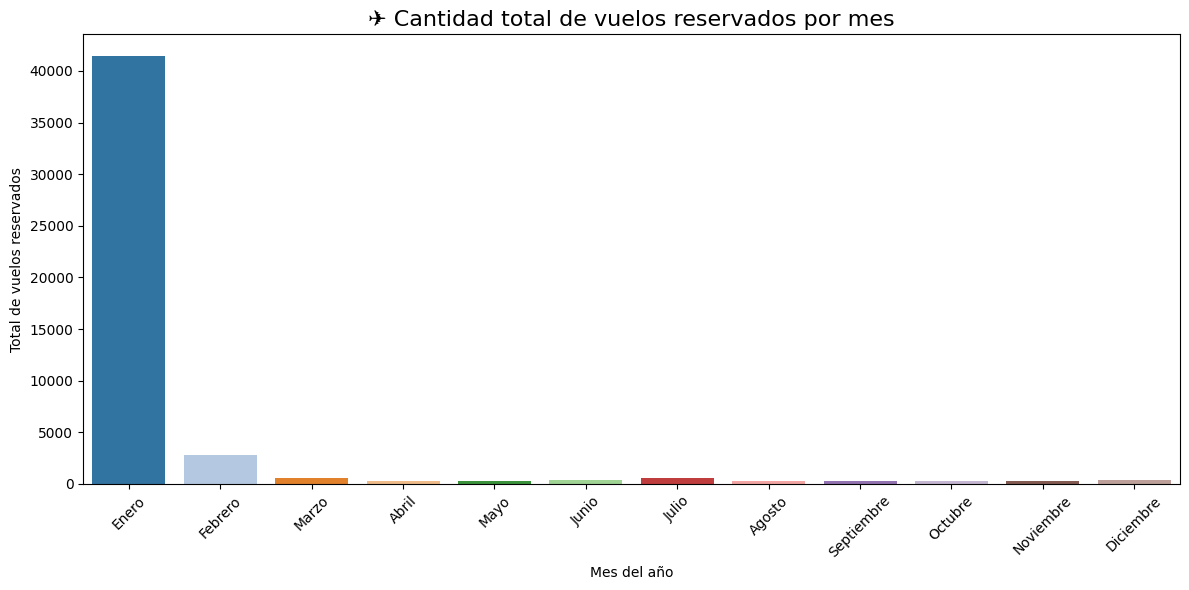

In [25]:
# Antes de nada, cargo/leo el nuevo CSV, para trabajar en los sucesivos gráficos a través de él:

full_customer_fixed = pd.read_parquet("Full Customer Fixed.parquet")

# Primero hago una agrupación por mes de la suma de los vuelos reservados, y lo guardo en una variable:

flights_by_month = full_customer_fixed.groupby('Month')['Flights Booked'].sum().sort_index()

# Gráfica:

month_names = ["Enero","Febrero","Marzo","Abril","Mayo","Junio",
               "Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]

plt.figure(figsize=(12,6))
sns.barplot(x=flights_by_month.index,
            y=flights_by_month.values,
            palette=sns.color_palette("tab20", 12))  # 12 colores distintos

plt.xticks(ticks=range(0,12), labels=month_names, rotation=45)
plt.title("✈️ Cantidad total de vuelos reservados por mes", fontsize=16)
plt.xlabel("Mes del año")
plt.ylabel("Total de vuelos reservados")
plt.tight_layout()
plt.show()

✈️📆 **Distribución de los vuelos reservados por mes**

He elegido un **gráfico de barras** porque es el tipo de visualización más clara para **comparar cantidades entre categorías**, en este caso los **12 meses del año**.  
Me permite ver fácilmente en qué meses se concentran más o menos reservas y comparar esas diferencias de un vistazo.

La gráfica de barras representa el **total de vuelos reservados (`Flights Booked`) por cada mes**:

- Los **meses con barras más altas** indican los **periodos de mayor demanda de vuelos**.  
- Los **meses con barras más bajas** corresponden a los **periodos con menor actividad de reservas**.  
- Este patrón revela la **estacionalidad de las reservas**, lo que es útil para **planificar recursos y estrategias de marketing** en las temporadas pico. Atípicamente, se puede observar como la mayoría de las reservas se concentran únicamente en el mes de Enero.

### 2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los cliente?


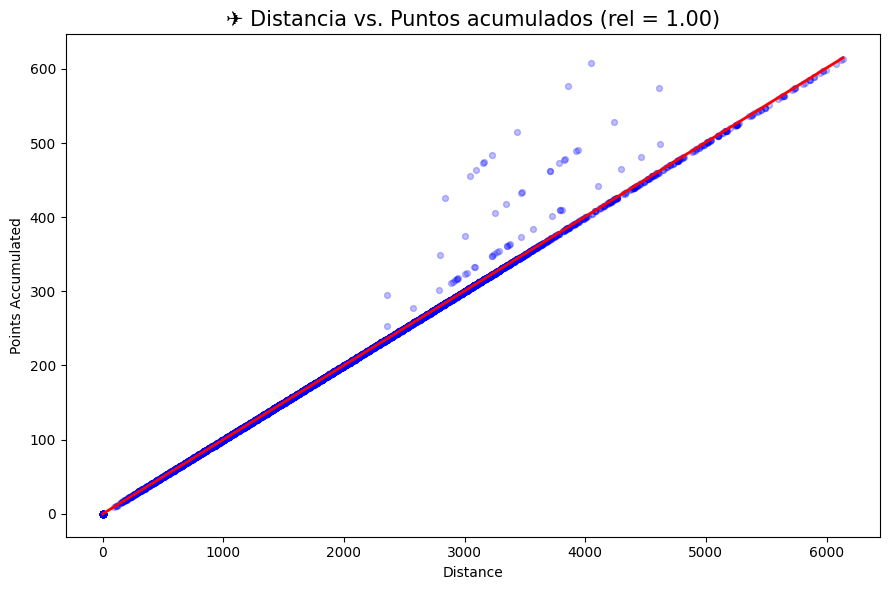

In [26]:
# Primero, la variable específica para esta relación:

distance_points = full_customer_fixed[['Distance', 'Points Accumulated']]

# Después, la de la correlación de Pearson:

rel = distance_points['Distance'].corr(distance_points['Points Accumulated'])

# Gráfica:

plt.figure(figsize=(9,6))

sns.regplot(
    data=distance_points,
    x='Distance',
    y='Points Accumulated',
    scatter_kws={'alpha':0.25, 's':18, 'color':'blue'},   # Azul para los puntos
    line_kws={'color':'red', 'linewidth':2}                    # Y línea en rojo
)

plt.title(f"✈️ Distancia vs. Puntos acumulados (rel = {rel:.2f})", fontsize=15)
plt.xlabel("Distance")
plt.ylabel("Points Accumulated")
plt.tight_layout()
plt.show()

✈️📈 **Relación entre la distancia de los vuelos y los puntos acumulados**

Elijo un **gráfico de dispersión** porque es la mejor forma de **visualizar la relación entre dos variables numéricas** (distancia y puntos) y verificar fácilmente el tipo de relación a partir de la nube de puntos y el valor de \( r \):  
- En el eje X coloco la **distancia de los vuelos**.  
- En el eje Y coloco los **puntos acumulados por los clientes**.  
- Cada punto representa un registro individual con ambos valores.

El gráfico permite observar **patrones y tendencias** que no se verían en tablas ni en histogramas.

La correlación \( r \) indica la fuerza y el sentido de la relación entre las dos variables:

- **r ≈ 0** → **Relación lineal débil o nula**: los puntos están dispersos y no hay un patrón claro.  
- **r > 0** → **Relación lineal positiva**: a mayor distancia, mayor número de puntos acumulados.  
- **r < 0** → **Relación lineal negativa**: a mayor distancia, menor número de puntos acumulados.

### 3. ¿Cuál es la distribución de los clientes por provincia o estado?


C:\Users\samai\AppData\Local\Temp\ipykernel_14584\1945426549.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


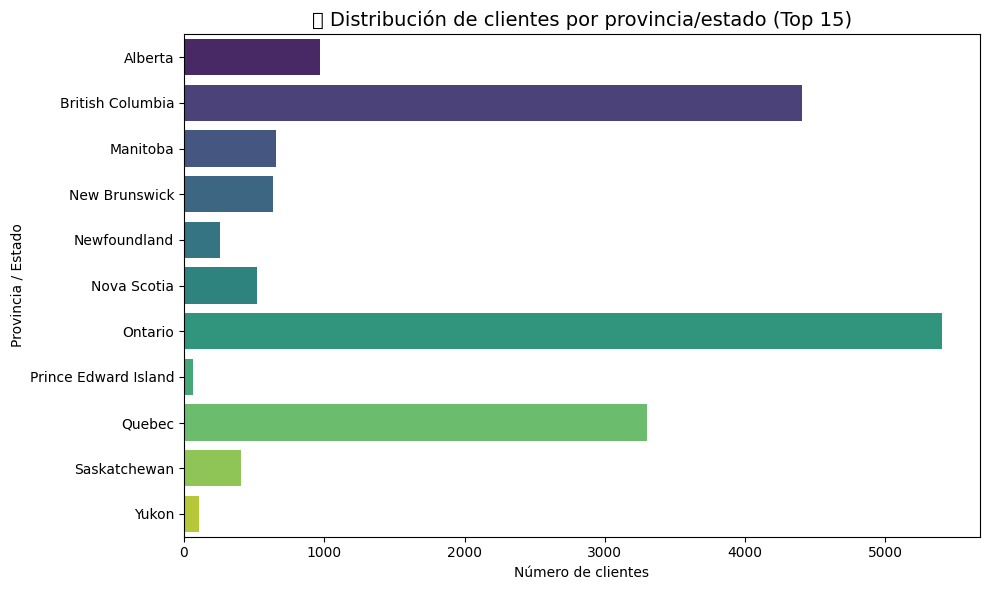

In [27]:
# Primero, hago el conteo de clientes por provincia/estado, y lo guardo en una variable:

province_counts = full_customer_fixed['Province'].value_counts()

# Luego, limito las provincias a las 15 principales para no saturar la gráfica:

top_n = 15
top_provinces = province_counts.head(top_n)

# Gráfica:

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_provinces.values,
    y=top_provinces.index,
    palette='viridis'        # Paleta de color en degradado
)

plt.title("📍 Distribución de clientes por provincia/estado (Top 15)", fontsize=14)
plt.xlabel("Número de clientes")
plt.ylabel("Provincia / Estado")
plt.tight_layout()
plt.show()


📍 **Distribución de los clientes por provincia/estado**

He elegido un **gráfico de barras horizontales** porque la variable **Provincia/Estado es categórica** y este tipo de gráfico permite:

- **Comparar fácilmente** el número de clientes entre distintas provincias.
- Mantener los nombres de las provincias legibles (especialmente si son muchos. De ahí la limitación a 15).
- Identificar de un vistazo las provincias con **mayor concentración de clientes**.

La gráfica muestra cuántos clientes hay en cada provincia/estado, ordenados de mayor a menor.  
Este tipo de análisis ayuda a:
- Detectar las **áreas geográficas más relevantes** para el negocio.
- Orientar **estrategias de marketing y logística** hacia las provincias con más clientes.


### 4. ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

In [28]:
# Antes de nada, voy a ver los valores únicos tal como están en el CSV, para poder ordenarlos en una lista (de menor a mayor nivel):

full_customer_fixed['Education'].unique()

['Bachelor', 'College', 'Master', 'High School or Below', 'Doctor']
Categories (5, object): ['Bachelor', 'College', 'Doctor', 'High School or Below', 'Master']

C:\Users\samai\AppData\Local\Temp\ipykernel_14584\3016402161.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
c:\Users\samai\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
c:\Users\samai\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
c:\Users\samai\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vert

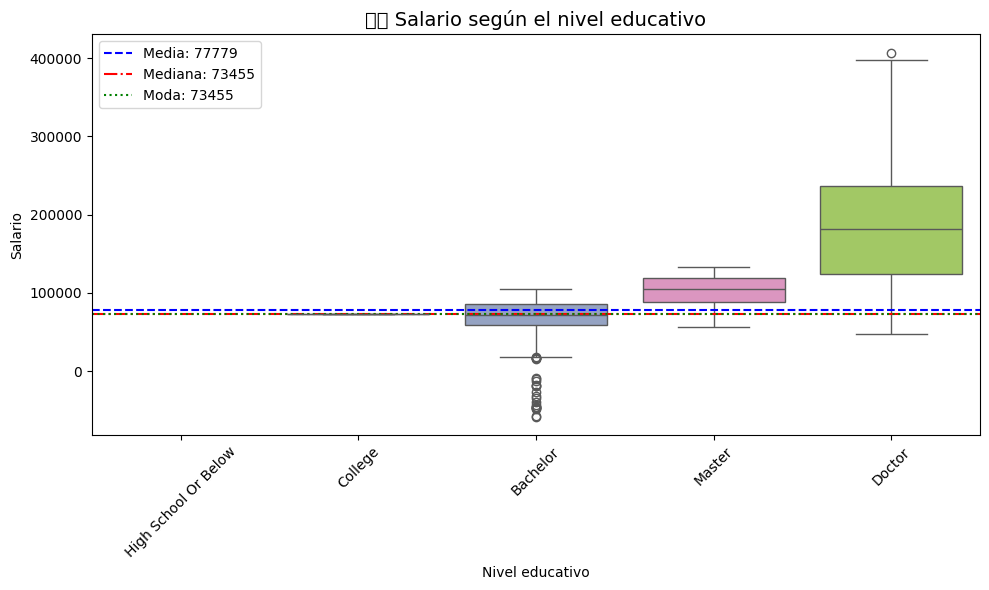

In [29]:
# Primero hago una lista con las categorías de nivel educativo en orden lógico de menor a mayor nivel:

edu_order = ['High School Or Below', 'College', 'Bachelor', 'Master', 'Doctor']

# Luego calculo en variables las métricas de media, mediana y moda de salario:

mean_salary = full_customer_fixed['Salary'].mean()
median_salary = full_customer_fixed['Salary'].median()
mode_salary = full_customer_fixed['Salary'].mode()[0] 

# Gráfica: 

plt.figure(figsize=(10,6))
sns.boxplot(
    data=full_customer_fixed,
    x='Education',
    y='Salary',
    order=edu_order,  # Meto la lista 
    palette='Set2'
)

plt.axhline(mean_salary, color='blue', linestyle='--', linewidth=1.5, label=f"Media: {mean_salary:.0f}")
plt.axhline(median_salary, color='red', linestyle='-.', linewidth=1.5, label=f"Mediana: {median_salary:.0f}")
plt.axhline(mode_salary, color='green', linestyle=':', linewidth=1.5, label=f"Moda: {mode_salary:.0f}")

plt.title("💰📚 Salario según el nivel educativo", fontsize=14)
plt.xlabel("Nivel educativo")
plt.ylabel("Salario")
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#💰📚 **Salario promedio según el nivel educativo**

He elegido un **gráfico de cajas (boxplot)** porque permite **comparar la distribución de un valor numérico (Salario) entre diferentes categorías (Niveles educativos)**.

El gráfico de cajas muestra la **distribución de los salarios** para cada nivel educativo, junto con las líneas horizontales que indican:

- 🔵 **Media** → ≈ 77.822  
- 🔴 **Mediana** → ≈ 73.455  
- 🟢 **Moda** → ≈ 73.455  

### Observaciones clave:
- Los clientes con **nivel Doctor** tienen claramente los **salarios más altos**, con una mediana muy por encima de la media global.  
- Los clientes con **nivel Master** presentan salarios superiores a la media y a la mediana globales, aunque con menor dispersión que el nivel Doctor.  
- Los niveles **Bachelor** y **College** se concentran alrededor de la mediana global, mostrando distribuciones más compactas.  
- El grupo **High School Or Below** tiene los **salarios más bajos**, situándose por debajo de la media y la mediana globales.  
- La presencia de **outliers** (puntos fuera de las cajas) es notable en los niveles Master y especialmente en Doctor, lo que indica algunos individuos con **salarios excepcionalmente altos** que elevan la media.

### Conclusión:
El análisis confirma que **a mayor nivel educativo, tiende a aumentar el salario**, aunque la dispersión también crece en los niveles superiores.  
La mediana global (roja) y la moda (verde) se sitúan por debajo de la media (azul), lo que revela una **asimetría positiva**: hay algunos clientes con salarios muy altos que empujan la media hacia arriba.

### 5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad? 

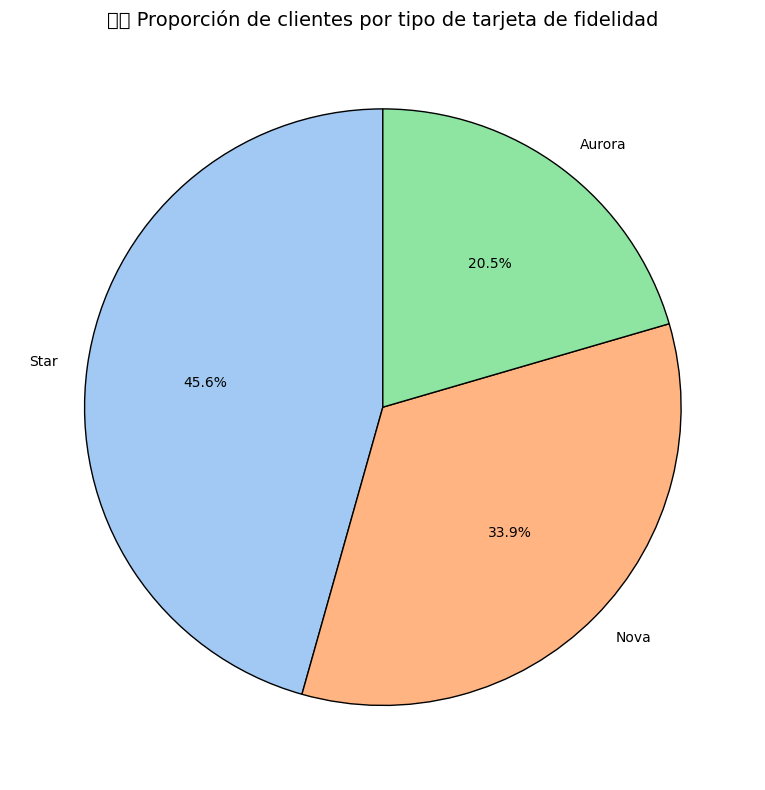

In [30]:
# Primero calculo las proporciones del "quesito" por cliente/tipo de tarjeta:

loyalty_counts = full_customer_fixed['Loyalty Card'].value_counts()
loyalty_proportions = loyalty_counts / loyalty_counts.sum()

# Crear gráfico circular
plt.figure(figsize=(8,8))
colors = sns.color_palette('pastel')[0:len(loyalty_counts)]
plt.pie(
    loyalty_counts,
    labels=loyalty_counts.index,
    autopct='%1.1f%%',           # mostrar porcentajes
    startangle=90,               # empieza desde arriba
    colors=colors,
    wedgeprops={'edgecolor':'black'}
)

plt.title("👥💳 Proporción de clientes por tipo de tarjeta de fidelidad", fontsize=14)
plt.tight_layout()
plt.show()

👥💳 **Proporción de clientes por tipo de tarjeta de fidelidad**

He elegido un **gráfico circular (pie chart)** porque es la forma más clara de mostrar la **proporción relativa de cada tipo de tarjeta** en el total de clientes.

### Observaciones:
- Cada sector representa el **porcentaje de clientes que posee cada tipo de tarjeta**.
- El tamaño visual de cada sector permite **comparar rápidamente cuál es el tipo de tarjeta más popular**.
- Si uno de los tipos domina el gráfico, indica que **la mayoría de los clientes se concentra en ese nivel de fidelidad**.
- Los tipos con proporciones pequeñas representan **nichos o segmentos minoritarios**, que podrían ser objetivo de estrategias de marketing específicas.

> Esta visualización facilita comprender **la estructura de la base de clientes según el tipo de tarjeta**, lo que puede guiar las decisiones para programas de fidelización y promociones.


### 6. ¿Cómo se distribuyen los clientes según su estado civil y género?

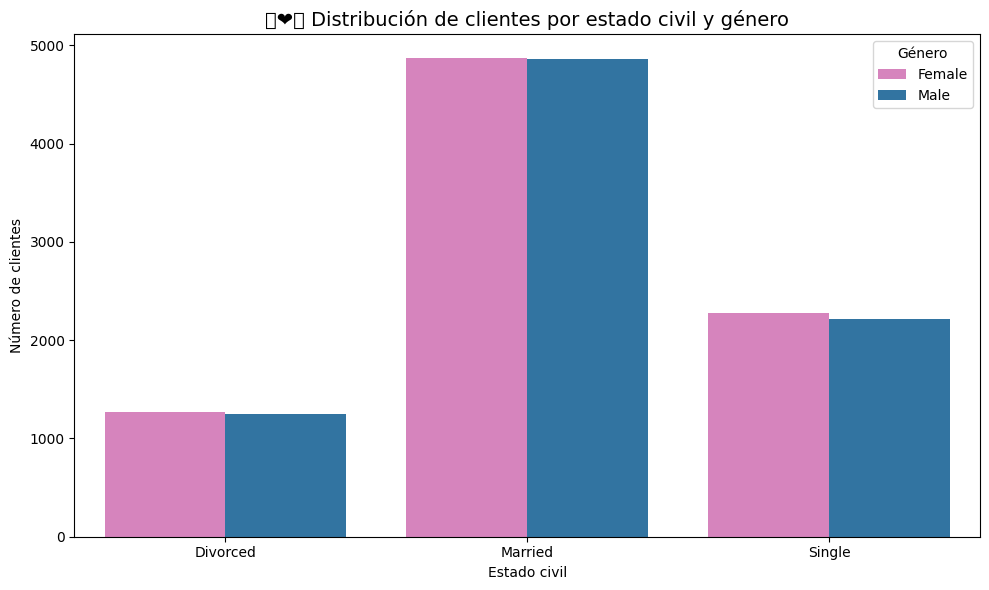

In [31]:
# Esta gráfica no requiere de cálculos o agrupaciones previas:

plt.figure(figsize=(10,6))

# Paleta de colores personalizada: Meto los clásicos de azul para hombres, rosa para mujeres.
gender_palette = {'Male': '#1f77b4', 'Female': '#e377c2'}
sns.countplot(
    data=full_customer_fixed,
    x='Marital Status',           # Estado civil
    hue='Gender',                 # Género
    palette=gender_palette
)

plt.title("👥❤️🚻 Distribución de clientes por estado civil y género", fontsize=14)
plt.xlabel("Estado civil")
plt.ylabel("Número de clientes")
plt.legend(title="Género")
plt.tight_layout()
plt.show()

👥❤️🚻 **Distribución de clientes por estado civil y género**

He elegido un **gráfico de barras agrupadas** porque es ideal para **comparar la frecuencia de clientes (variable categórica) cruzando dos categorías: estado civil y género**.

### Observaciones:
- Cada grupo de barras muestra el número de clientes de cada **estado civil**, desglosado por **género**.
- Permite ver no solo cuál es el estado civil predominante, sino también **las diferencias entre géneros dentro de cada estado civil**.
- Si un estado civil domina el gráfico, indica que **es la situación más común en la base de clientes**.
- Las barras de diferente color dentro de cada grupo ayudan a detectar **posibles sesgos de género** en los diferentes estados civiles.

> Esta visualización permite entender la **composición demográfica** de los clientes combinando dos variables clave: su **situación civil y su género**.


### BONUS Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

Utilizando el conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes. Tendremos en mente que los datos que tenemos son solo una muestra de una población. Para ello, los pasos que deberás seguir son: 

1. **Preparación de Datos:**
Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.

In [32]:
# Primero cargo el csv y lo guardo en este nuevo df para la comparativa:

comparative_df = pd.read_parquet("Full Customer Fixed.parquet")

In [33]:
# Como ya me pasó que la columna 'Education' mostraba los valores desordenados y los tuve que organizar para la visualización...
# Voy a crear una pequeña función, antes de empezar a filtrar, para dejarla ordenada.

def order_education(df, order=("High School Or Below", "College", "Bachelor", "Master", "Doctor")):
    df["Education"] = pd.Categorical(df["Education"], categories=list(order), ordered=True)

order_education(comparative_df)

In [35]:
comparative_df = comparative_df[["Flights Booked", "Education"]]
comparative_df.head()

Flights Booked Education
0               3  Bachelor
1              10   College
2               6   College
3               0  Bachelor
4               0  Bachelor

2. **Análisis Descriptivo:**
Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, mediana, la desviación estándar) del número de vuelos reservados para cada grupo. Aquí, utilizamos estadística descriptiva normal.

In [45]:
# Estadística descriptiva por nivel educativo:

descriptive_stats = (
    comparative_df
      .groupby("Education")["Flights Booked"]
      .agg(N="count", mean="mean", median="median", Std="std")
      .round({"Mean": 2, "Median": 2, "Std": 2})
      .reset_index()
)

descriptive_stats.to_parquet("Descriptive Stats.parquet", index=False)

3. **Prueba Estadística:**
Realiza una prueba de hipótesis para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos. Aquí utilizamos estadística inferencial.

In [42]:
# Primero creo las máscaras/filtros para los diferentes grupos (según nivel educativo):

flights_high_school_or_below  = comparative_df[comparative_df["Education"] == "High School Or Below"]["Flights Booked"]
flights_college               = comparative_df[comparative_df["Education"] == "College"]["Flights Booked"]
flights_bachelor              = comparative_df[comparative_df["Education"] == "Bachelor"]["Flights Booked"]
flights_master                = comparative_df[comparative_df["Education"] == "Master"]["Flights Booked"]
flights_doctor                = comparative_df[comparative_df["Education"] == "Doctor"]["Flights Booked"]

In [ ]:
# Ahora ejecuto la super-mega-ultra-plus-wonderfull función de Rocío:

def prueba_hipotesis(*args):
    """
    Realiza una prueba de hipótesis para comparar grupos.
    1. Primero verifica si los datos son normales usando el test de Shapiro-Wilk o Kolmogorov-Smirnov.
    2. Si los datos son normales, usa Bartlett para probar igualdad de varianzas. Si no son normales, usa Levene.
    3. Si las varianzas son iguales, usa el t-test de Student; si no, usa la versión de Welch.
    4. Si los datos no son normales, usa el test de Mann-Whitney

    Parámetros:
    *args: listas o arrays con los datos de cada grupo. Espera DOS grupos a comparar

    Retorna:
    dict con resultados del test de normalidad, varianza e hipótesis.
    """
    
    # Verificar si hay al menos dos grupos
    if len(args) < 2:
        raise ValueError("Se necesitan al menos dos conjuntos de datos para realizar la prueba.")
    
    # Comprobar normalidad en cada grupo
    normalidad = []
    for grupo in args:
        if len(grupo) > 50: #aquí vamos a decidir hacer komogorov porque es más potente y shapiro solo en muestras pequeñas
            p_valor_norm = stats.kstest(grupo, 'norm').pvalue  # Kolmogorov-Smirnov si n > 50
        else:
            p_valor_norm = stats.shapiro(grupo).pvalue  # Shapiro-Wilk si n <= 50
        normalidad.append(p_valor_norm > 0.05)

    datos_normales = all(normalidad)  # True si todos los grupos son normales, all() solo devuelve True si todos los elementos son True

    # Prueba de igualdad de varianzas
    if datos_normales:
        p_valor_varianza = stats.bartlett(*args).pvalue  # Test de Bartlett si los datos son normales
    else:
        p_valor_varianza = stats.levene(*args, center="median").pvalue  # Test de Levene si no son normales

    varianzas_iguales = p_valor_varianza > 0.05

    # Aplicar el test adecuado
    if datos_normales:
        if varianzas_iguales:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=True)
            test_usado = "t-test de Student (varianzas iguales)"
        else:
            t_stat, p_valor = stats.ttest_ind(*args, equal_var=False)
            test_usado = "t-test de Welch (varianzas desiguales)"
    else:
        t_stat, p_valor = stats.mannwhitneyu(*args)
        test_usado = "Mann-Whitney U"

    # Nivel de significancia
    alfa = 0.05

    # Resultados
    resultado = {
        "Test de Normalidad": normalidad,
        "Datos Normales": datos_normales,
        "p-valor Varianza": p_valor_varianza,
        "Varianzas Iguales": varianzas_iguales,
        "Test Usado": test_usado,
        "Estadístico": t_stat,
        "p-valor": p_valor,
        "Conclusión": "Rechazamos H0. Es decir, sí hay diferencias significativas)" if p_valor < alfa else "No se rechaza H0. Es decir, no hay diferencias significativas)"
    }

    # Imprimir resultados de manera más clara
    print("\n📊 **Resultados de la Prueba de Hipótesis** 📊")
    print(f"✅ Test de Normalidad: {'Sí' if datos_normales else 'No'}")
    print(f"   - Normalidad por grupo: {normalidad}")
    print(f"✅ Test de Varianza: {'Iguales' if varianzas_iguales else 'Desiguales'} (p = {p_valor_varianza:.4f})")
    print(f"✅ Test aplicado: {test_usado}")
    print(f"📉 Estadístico: {t_stat:.4f}, p-valor: {p_valor:.4f}")
    print(f"🔍 Conclusión: {resultado['Conclusión']}\n")

In [51]:
# Y ¡milagro! ya se la puedo ir pasando a cada par de grupos a comparar.

# Voy a aplicar sólo a dos (los más opuestos) para este ejercicio.

# Ejecuto la prueba:

hipotesis_1 = prueba_hipotesis(flights_high_school_or_below, flights_doctor)

# Lo paso a DataFrame y lo guardo a parquet:

hipotesis_1_df = pd.DataFrame([hipotesis_1])

hipotesis_1_df.to_parquet("Hipótesis 1.parquet", index=False)


📊 **Resultados de la Prueba de Hipótesis** 📊
✅ Test de Normalidad: No
   - Normalidad por grupo: [np.False_, np.False_]
✅ Test de Varianza: Desiguales (p = nan)
✅ Test aplicado: Mann-Whitney U
📉 Estadístico: nan, p-valor: nan
🔍 Conclusión: No se rechaza H0. Es decir, no hay diferencias significativas)

